In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV


In [5]:
# Load data
df = pd.read_csv(r'./data/processed-data.csv')

In [6]:
# Feature engineering
df['lat_diff'] = df['latitude_2'] - df['latitude_1']
df['lon_diff'] = df['longitude_2'] - df['longitude_1']
df['same_state'] = (df['state_1'] == df['state_2']).astype(int)
df['route'] = df['airport_iata_1'] + "-" + df['airport_iata_2']

In [7]:
# Bin distances into categories
df['distance_bin'] = pd.cut(df['nsmiles'],
                            bins=[0, 500, 1500, 3000, 6000],
                            labels=['short', 'medium', 'long', 'ultra'])

In [8]:
# Drop leaky or non-web-usable columns
drop_cols = ['passengers', 'fare_lg', 'fare_low', 'large_ms', 'lf_ms']
df = df.drop(columns=drop_cols)

In [9]:
# Target variable
y = df['fare']
X = df.drop(columns=['fare'])

In [10]:
usable_features = [
    'year', 'quarter', 'season', 
    'airport_iata_1', 'airport_iata_2',
    'state_1', 'state_2',
    'latitude_1', 'longitude_1',
    'latitude_2', 'longitude_2',
    'nsmiles',
    'lat_diff', 'lon_diff', 'same_state', 'route', 'distance_bin'
]
X = df[usable_features]

In [11]:
# Categorical & numerical split
cat_features = ['year', 'quarter', 'season', 'airport_iata_1', 'airport_iata_2',
                'state_1', 'state_2', 'route', 'distance_bin']
num_features = ['latitude_1', 'longitude_1', 'latitude_2', 'longitude_2',
                'nsmiles', 'lat_diff', 'lon_diff', 'same_state']

In [12]:
# Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='passthrough'  # Keep numeric features as is
)

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
### === XGBoost Model === ###
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

In [ ]:
# Evaluation
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Avoid division by zero in MAPE
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  MAPE: {mape:.2f}%")

evaluate_model("XGBoost", y_test, y_pred_xgb)


XGBoost Performance:
  MSE : 3189.36
  RMSE: 56.47
  MAE : 37.54
  R²  : 0.52
  MAPE: 18.76%


In [ ]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
}

search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    n_jobs=1,    
    verbose=2
)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=100; total time= 1.3min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=100; total time= 1.4min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=100; total time= 1.9min
[CV] END regressor__learning_rate=0.01, regressor__max_depth=8, regressor__n_estimators=200; total time= 3.8min
[CV] END regressor__learning_rate=0.01, regressor__max_depth=8, regressor__n_estimators=200; total time= 5.7min
[CV] END regressor__learning_rate=0.01, regressor__max_depth=8, regressor__n_estimators=200; total time= 8.2min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=8, regressor__n_estimators=100; total time= 1.9min
[CV] END regressor__learning_rate=0.1, regressor__max_depth=8, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__learning_rate=0.1, regressor

<Figure size 1000x600 with 0 Axes>

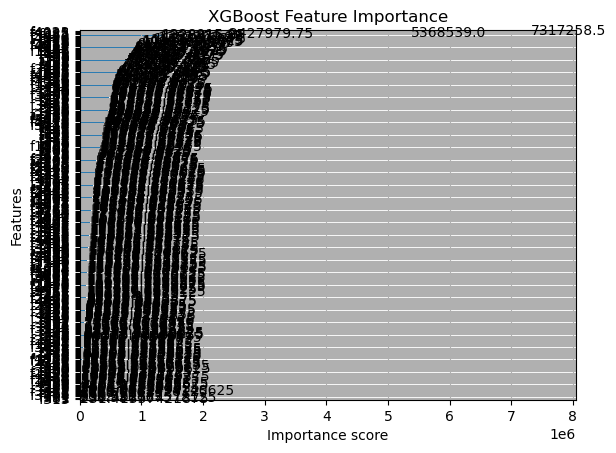

In [16]:
import matplotlib.pyplot as plt

# After fitting the model
xgb_model = xgb_pipeline.named_steps['regressor']
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()

In [17]:
# New model with best params
best_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.3,
        random_state=42,
        objective='reg:squarederror'
    ))
])

best_xgb_pipeline.fit(X_train, y_train)
y_pred = best_xgb_pipeline.predict(X_test)

In [18]:
evaluate_model("Tuned XGBoost", y_test, y_pred)


Tuned XGBoost Performance:
  MSE : 2650.79
  RMSE: 51.49
  MAE : 32.01
  R²  : 0.60
  MAPE: 15.48%


In [19]:
joblib.dump(best_xgb_pipeline, "xgb_airfare_model.pkl")

['xgb_airfare_model.pkl']